# Building An Object-Oriented Simulation - Lab

## Introduction

In this lab, we'll build a stochastic simulation to model herd immunity in a population, and examine how a virus moves through a population, depending on what percentage of the population is vaccinated against the disease. 

## Objectives

You will be able to:

* Understand the OO lifecycle, and the relationship between attributes and methods
* Create Object-Oriented data models that describe the real world with classes 

<img src='herd_immunity.gif'>

In the previous lesson, we outlined the various steps we'll take to create this simulation.  In this lab, we'll actually build it! 

Since we'll be building a stochastic simulation that makes use of randomness, we'll start by importing numpy and setting a random seed for reproducibility.

Run the cell below to do this now. 

In [1]:
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
np.random.seed(0)

/Users/rwilley/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## The Assumptions of Our Model

In order to build this stochastic simulation, we'll have to accept some assumptions.  In order to simplify the complexity of the model, we'l assume:

* Vaccines are 100% effective.
* Infected individuals that recover from the disease are now immune to catching the disease a second time (think Chickenpox)
* Dead invidiuals are not contagious. 
* All infections happen from person-to-person interaction
* All individuals interact with the same amount of people each day
* The `r0` value (pronounced _"R-nought"_) is a statistic from the Centers for Disease Control that estimates the average number of people an infected person will infect before they are no longer contagious.  For this value, we assume:
    * That this number is out of 100 people
    * That this statistic is accurate
    
Building simulations is always a trade-off, since the real world is very, very complex.  As we build our simulation, try to think about ways in which we could make our model more realistic by writing it in such a way that it eliminates one of the assumptions above (e.g. generating a float value for vaccine efficacy on a person-by-person level to eliminate our first assumption). 


### Building our `Person` class

We'll start by building out our `Person` class, which will represent the individuals in our population. 

Our `Person` class should have the following attributes:

* `is_alive = True` 
* `is_vaccinated`, a boolean value which will be determined by generating a random value between 0 and 1.  We will then compare this to `(1 - pct_vaccinated)`, a variable that should be passed in at instantiation time.  If the random number is greater, then this attribute should be `True`-- otherwise, `False`
* `is_infected = False`
* `has_been_infected = False`
* `newly_infected = False`

In the cell below, complete the `Person` class.

**_NOTE:_** To generate a random number between 0 and 1, use `np.random.random()`. 

In [2]:
class Person(object):
    
    def __init__(self, pct_vaccinated):
        self.is_alive = True
        self.is_vaccinated = False
        self.is_infected = False
        self.has_been_infected = False
        self.newly_infected = False
        
    def get_vaccinated(self, pct_vaccinated):
        if (1 - pct_vaccinated) < np.random.random():
            self.is_vaccinated = True

Great! Since we're using OOP to build this simulation, it makes sense to have each individual `Person` instance take care of certain details, such as determining if they are vaccinated or not.  The `pct_vaccinated` argument is a value we'll pass into the `Simulation` class, which we can then pass along to each `Person` once our population is created to vaccinate the right amount of people.  

## Creating our `Simulation` Class

Creating our `Simulation` class will be a bit more involved, because this class does all the heavy lifting.  We'll handle this piece by piece, and test that everything is working along the way. 

### Writing our `__init__` method

Our init method should take in the following arguments at instantiation time:

* `self` 
* `population_size`
* `disease_name`
* `r0`
* `mortality_rate`
* `total_time_steps`
* `pct_vaccinated`
* `num_initial_infected`

**_Attributes_**

The attributes `self.disease_name`, `self.mortality_rate`, and `self.total_time_steps` should be set to the corresponding arguments passed in at instantiation time. 

The attribute `self.r0` should be set to set to `r0 / 100` to convert the number to a decimal between 0 and 1.

We'll also create attributes for keeping track of what time step the simulation is on, as well as both the current number of infected during this time step and the total number of people that have been infected at any time during the simulation.  For these, set `self.current_time_step`, `self._total_infected_counter`, and `self.current_infected_counter` to  `0`.

We'll also need to create an array to hold all of the `Person` objects in our simulation.  Set `self.population` equal to an empty list.  


Now comes the fun part--creating the population, and determining if they are healthy, vaccinated, or infected.  

Follow the instructions inside the `__init__` method to write the logic that will set up our `Simulation` correctly. 


In [3]:
class Simulation(object):
    
    def __init__(self, population_size, disease_name, r0, mortality_rate,  total_time_steps, pct_vaccinated, num_initial_infected):
        self.r0 = r0 / 100
        self.disease_name = disease_name
        self.mortality_rate = mortality_rate
        self.total_time_steps = total_time_steps
        self.current_time_step = 0
        self.total_infected_counter = 0
        self.current_infected_counter = 0
        self.dead_counter = 0
        self.population = []
        # This attribute is used in a function that is provided for you in order to log statistics from each time_step.  
        # Don't touch it!
        self.time_step_statistics_df = pd.DataFrame()
        
        # Create a for loop the size of the population we want in this simulation
        for i in range(0, population_size):
            # Create new person
            new_person = Person(pct_vaccinated)
            # We'll add infected persons to our simulation first.  Check if the current number of infected are equal to the 
            # num_initial_infected parameter.  If not, set new_person to be infected
            if self.current_infected_counter != num_initial_infected:
                new_person.is_infected = True
                # dont forget to increment both infected counters!
                self.total_infected_counter += 1
                self.current_infected_counter += 1
            # if new_person is not infected, determine if they are vaccinated or not by using their `get_vaccinated` method
            # Then, append new_person to self.population
            else:
                new_person.get_vaccinated(pct_vaccinated)
            self.population.append(new_person)
       
        print("-" * 50)
        print("Simulation Initiated!")
        print("-" * 50)
        self._get_sim_statistics()
        
        
    
    def _get_sim_statistics(self):
    # In the interest of time, this method has been provided for you.  No extra code needed.
        num_infected = 0
        num_dead = 0
        num_vaccinated = 0
        num_immune = 0
        for i in self.population:
            if i.is_infected:
                num_infected += 1
            if not i.is_alive:
                num_dead += 1
            if i.is_vaccinated:
                num_vaccinated += 1
                num_immune += 1
            if i.has_been_infected:
                num_immune += 1
        assert num_infected == self.current_infected_counter
        assert num_dead == self.dead_counter
        
        
        print("")
        print("Summary Statistics for Time Step {}".format(self.current_time_step))
        print("")
        print("-" * 50)
        print("Disease Name: {}".format(self.disease_name))
        print("R0: {}".format(self.r0 * 100))
        print("Mortality Rate: {}%".format(self.mortality_rate * 100))
        print("Total Population Size: {}".format(len(self.population)))
        print("Total Number of Vaccinated People: {}".format(num_vaccinated))
        print("Total Number of Immune: {}".format(num_immune))
        print("Current Infected: {}".format(num_infected))
        print("Deaths So Far: {}".format(num_dead))     

Great! We've now created a basic `Simulation` object that is capable of instantiating itself according to our specifications.  However, our simulation doesn't currently do anything.  Now, we'll add the appropriate behaviors to our simulation. 

### Building Our Simulation's Behavior

For any given time step, our simulation should complete the following steps in order:

1. Loop through each living person in the population
    1A. If the person is currently infected:
        1B. Select another random person from the population. 
        2B. If this person is alive, not infected, unvaccinated, and hasn't been infected before: 
            1C. Generate a random number between 0 and 1.  If this random number is greater than `(1 - self.r0)`, then mark this new person as newly infected
        3B.If the person is vaccinated, currently infected, or has been infected in a previous round of the simulation, do nothing. 
    2A. Repeat the step above until the infected person has interacted with 100 random living people from the population. 
2. Once every infected person has interacted with 100 random living people, resolve all current illnesses and new infections
    2A. For each person that started this round as infected, generate a random number between 0 and 1.  If that number is greater than `(1 - mortality rate)`, then that person has been killed by the disease.  They should be marked as dead.  Otherwise, they stay alive, and can longer catch the disease.
    2B.  All people that were infected this round move from `newly_infected` to `is_infected`. 
    
We'll begin by breaking up most of this logic into helper functions, so that our main functions will be simple.  
    
#### `infected_interaction()` Function

We'll begin by writing a function called `infected_interaction` that will be called for every infected person in the population in a given time step.  This function handles all the possible cases that can happen with the following logic:

* Initialize a counter called `num_interactions` to `0`.
* Select a random person from `self.population`.
* Check is the person is alive. If the person is dead, we will not count this as an interaction.
* If the random person is alive and not vaccinated, generate a a random number between 0 and 1.  If the random number is greater than `(1 - self.r0)`, change the random person's `newly_infected` attribute to `True`.
* Increment `num_interactions` by 1.  Do not increment any of the infected counters in the simulation class--we'll have another method deal with those.

Complete the `infected_interaction()` method in the cell below.  Comments have been provided to help you write it.

**_HINT_**: To randomly select an item from a list, use `np.random.choice()`!

In [4]:
def infected_interaction(self, infected_person):
    num_interactions = 0
    while num_interactions < 100:
        # Randomly select a person from self.population
        random_person = np.random.choice(self.population)
        # This only counts as an interaction if the random person selected is alive.  If the person is dead, we do nothing, 
        # and the counter doesn't increment, repeating the loop and selecting a new person at random.
        # check if the person is alive.
        if random_person.is_alive:
            # CASE: Random person is not vaccinated, and has not been infected before, making them vulnerable to infection
            if random_person.is_vaccinated == False and random_person.has_been_infected == False:
                # Generate a random number between 0 and 1
                random_number = np.random.random()
                # If random_number is greater than or equal to (1 - self.r0), set random person as newly_infected
                if random_number >= (1 - self.r0):
                    random_person.newly_infected = True
            # Dont forget to increment num_interactions, and make sure it's at this level of indentation
            num_interactions += 1

# Adds this function to our Simulation class
Simulation.infected_interaction = infected_interaction

#### `_resolve_states()` Function

The 2nd helper function we'll use during each time step is one that resolves any temporary states.  Recall that people do not stay newly infected or infected for more than a turn.  That means we need a function to figure out what happens to these people at the end of each turn, so that everything is ready to go for the next time step. 

This function will:

* Iterate through every person in the population.
* Check if the person is alive (since we dont need to bother checking anything for the dead ones)
* If the person is infected, we need to resolve whether they survive the infection or die from it.  
    * Generate a random number between 0 and 1.  
    * If this number is greater than `(1 - self.mortality_rate)`, the person has died.  
        * Set the person's `.is_alive` and `.is_infected` attributes both to `False`.  
        * Increment the simulation's `self.dead_counter` attribute by 1.
        * Decrement the simulation's `self.current_infected_counter` attribute by 1.
    * Else, the person has survived the infection and is now immune to future infections.
        * Set the person's `is_infected` attribute to `False`
        * Set the person's `has_been_infected` attribute to `True`
        * Decrement the simulation's `self.current_infected_counter` by 1.
* If the person is newly infected:
    * Set the person's `newly_infected` attribute to `False`
    * Set the person's `is_infected` attribute to `True`
    * Increment `total_infected_counter` and `current_infected_counter` by 1.
    

Complete the function `_resolve_states()` in the cell below.  Comments have been provided to help you write it. 

In [5]:
def _resolve_states(self):
    """
    Every person in the simulation falls into 1 of 4 states at any given time:
    1. Dead 
    2. Alive and not infected
    3. Currently infected
    4. Newly Infected
    
    States 1 and 2 need no resolving, but State 3 will resolve by either dying or surviving the disease, and State 4 will resolve
    by turning from newly infected to currently infected.
    
    This method will be called at the end of each time step.  All states must be resolved before the next time step can begin.
    """
    # Iterate through each person in the population
    for person in self.population:
        # We only need to worry about the people that are still alive
        if person.is_alive: 
            # CASE: Person was infected this round.  We need to stochastically determine if they die or recover from the disease
            # Check if person is_infected
            if person.is_infected:
                # Generate a random number
                random_number = np.random.random()
                # If random_number is >= (1 - self.mortality_rate), set the person to dead and increment the simulation's death
                # counter
                if random_number >= (1 - self.mortality_rate):
                    # Set is_alive and in_infected both to False
                    person.is_alive = False
                    person.is_infected = False
                    # Don't forget to increment self.dead_counter, and decrement self.current_infected_counter
                    self.dead_counter += 1
                    self.current_infected_counter -= 1
                else:
                    # CASE: They survive the disease and recover.  Set is_infected to False and has_been_infected to True
                    person.is_infected = False
                    person.has_been_infected = True
                    # Don't forget to decrement self.current_infected_counter!
                    self.current_infected_counter -= 1
            # CASE: Person was newly infected during this round, and needs to be set to infected before the start of next round
            elif person.newly_infected:
                # Set is_infected to True, newly_infected to False, and increment both self.current_infected_counter and 
                # self.total_infected_counter
                person.is_infected = True
                person.newly_infected = False
                self.current_infected_counter += 1
                self.total_infected_counter += 1
                
Simulation._resolve_states = _resolve_states

#### `_time_step()` Function

Now that we have two helper methods to most of the heavy lifting for us, we'll find that our `_time_step()` function will be pretty simple.  

This function should:

* Iterate through each person in the population
* If the person is alive and infected, call `self.infected_interaction()` and pass in this infected person
* Once we have looped through every person, call `self._resolve_states()` to resolve all outstanding states and prepare for the next round.  
* Log the statistics from this round by calling `self._log_time_step_statistics()`.  This function has been provided for you further down the notebook. 
* Increment `self.current_time_step`.

In [6]:
def _time_step(self):
    """
    Compute 1 time step of the simulation. This function will make use of the helper methods we've created above. 
    
    The steps for a given time step are:
    1.  Iterate through each person in self.population.
        - For each infected person, call infected_interaction() and pass in that person.
    2.  Use _resolve_states() to resolve all states for the newly infected and the currently infected.
    3. Increment self.current_time_step by 1. 
    """
    # Iterate through each person in the population
    for person in self.population:
        # Check only for people that are alive and infected
        if person.is_alive and person.is_infected:
            # Call self.infected_interaction() and pass in this infected person
            self.infected_interaction(person)
    
    # Once we've made it through the entire population, call self._resolve_states()
    self._resolve_states()
    
    # Now, we're almost done with this time step.  Log summary statistics, and then increment self.current_time_step by 1.
    self._log_time_step_statistics()
    self.current_time_step += 1

# Adds this function to our Simulation class
Simulation._time_step = _time_step

Finally, we just need to write a function that logs the results of each time step by storing it in a DataFrame, and then writes the end result of the Simulation to a csv file.

In the interest of time, this function has been provided for you.  You do not need to write any code in the cell below--just run the cell.

In [7]:
def _log_time_step_statistics(self, write_to_file=False):
    # This function has been provided for you, you do not need to write any code for it.
    # Gets the current number of dead,
    # CASE: Round 0 of simulation, need to create and Structure DataFrame
#     if self.time_step_statistics_df == None:
#         import pandas as pd
#         self.time_step_statistics_df = pd.DataFrame()
# #         col_names = ['Time Step', 'Currently Infected', "Total Infected So Far" "Alive", "Dead"]
# #         self.time_step_statistics_df.columns = col_names
#     # CASE: Any other round
#     else:
        # Compute summary statistics for currently infected, alive, and dead, and append them to time_step_snapshots_df
    row = {
        "Time Step": self.current_time_step,
        "Currently Infected": self.current_infected_counter,
        "Total Infected So Far": self.total_infected_counter,
        "Alive": len(self.population) - self.dead_counter,
        "Dead": self.dead_counter
    }
    self.time_step_statistics_df = self.time_step_statistics_df.append(row, ignore_index=True)
    
    if write_to_file:
        self.time_step_statistics_df.to_csv("simulation.csv", mode='w+')
        
Simulation._log_time_step_statistics = _log_time_step_statistics

#### Wrapping It All Up With `run()`

This is the function that our user will actually interact with. It will act as our "main" function.  Since we've done a great job of writing very clean, modular helper functions, we'll find that this function is the simplest one in the entire program. 

This function should:

* Start a for loop that runs `self.total_time_steps` number of times.  In order to demonstrate how to easily add a progress bar to iterables with the `tqdm` library, this line has been added for you. 
* Display a message telling the user the time step that it is currently working on. 
* Call `self._time_step()`
* Once the simuluation has finished, write the DataFrame containing the summary statistics from each step to a csv file.  This line of code has also been provided for you. 

In the cell below, complete the `run()` function.  Comments have been added to help you write it. 

In [8]:
def run(self):
    """
    The main function of the simulation.  This will run the simulation starting at time step 0, calculating
    and logging the results of each time step until the final time_step is reached. 
    """
    
    for _ in tqdm(range(self.total_time_steps)):
        # Print out the current time step 
        print("Beginning Time Step {}".format(self.current_time_step))
        # Call our `_time_step()` function
        self._time_step()
    
    # Simulation is over--log results to a file by calling _log_time_step_statistics(write_to_file=True)
    self._log_time_step_statistics(write_to_file=True)

# Adds the run() function to our Simulation class.
Simulation.run = run

### Running Our Simulation

Now comes the fun part--actually running our simulation!

In the cell below, create a simulation with the following parameters:

* Population size of `2000`
* Disease name is `Ebola`
* r0 value of `2`
* Mortality rate of `0.5`
* `20` time steps
* Vaccination Rate of `0.85`
* `50` initial infected

In [17]:
sim = Simulation(2000, 'Ebola', 2, 0.5,  20, .85, 50)

--------------------------------------------------
Simulation Initiated!
--------------------------------------------------

Summary Statistics for Time Step 0

--------------------------------------------------
Disease Name: Ebola
R0: 2.0
Mortality Rate: 50.0%
Total Population Size: 2000
Total Number of Vaccinated People: 1663
Total Number of Immune: 1663
Current Infected: 50
Deaths So Far: 0


In [18]:
sim.run()

Beginning Time Step 0
Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10
Beginning Time Step 11
Beginning Time Step 12
Beginning Time Step 13
Beginning Time Step 14
Beginning Time Step 15
Beginning Time Step 16
Beginning Time Step 17
Beginning Time Step 18
Beginning Time Step 19



In [19]:
results = pd.read_csv('simulation.csv')
results

,Unnamed: 0,Alive,Currently Infected,Dead,Time Step,Total Infected So Far
0,0,1973.0,15.0,27.0,0.0,65.0
1,1,1972.0,8.0,28.0,1.0,73.0
2,2,1968.0,2.0,32.0,2.0,75.0
3,3,1968.0,0.0,32.0,3.0,75.0
4,4,1968.0,0.0,32.0,4.0,75.0
5,5,1968.0,0.0,32.0,5.0,75.0
6,6,1968.0,0.0,32.0,6.0,75.0
7,7,1968.0,0.0,32.0,7.0,75.0
8,8,1968.0,0.0,32.0,8.0,75.0
9,9,1968.0,0.0,32.0,9.0,75.0


If you didn't change the random seed, your results should look like this:

<img src='example_sim_results.png'>

As we can see from the table above, even though the average person with Ebola will infect 2 other people, herd immunity protects 
the majority of the unvaccinated people in the population.  Although there were approximately 400 people in the population that were susceptible to Ebola, only 67 were actually infected before the virus burned itself out!

## Extra Practice

Try different values for the `pct_vaccinated` argument, and see how it changes the results of the model.  These would look great as a visualization--consider comparing them all on the same line graph!

## Summary

Great job! You've just written a simulation to demonstrate the effects of herd immunity in action. 

In this lab, we demonstated mastery of:

* Understanding the OO lifecycle , and the relationship between attributes and methods
* Creating Object-Oriented data models that describe the real world with classes

In [20]:
vac_rates = [0.5, 0.75, 0.85, 0.90]

results_list = []
for rate in vac_rates:
    sim = Simulation(2000, 'Ebola', 2, 0.5,  20, rate, 50)
    sim.run()
    results_list.append(pd.read_csv('simulation.csv'))

# sim = Simulation(2000, 'Ebola', 2, 0.5,  20, .85, 50)

--------------------------------------------------
Simulation Initiated!
--------------------------------------------------

Summary Statistics for Time Step 0

--------------------------------------------------
Disease Name: Ebola
R0: 2.0
Mortality Rate: 50.0%
Total Population Size: 2000
Total Number of Vaccinated People: 974
Total Number of Immune: 974
Current Infected: 50
Deaths So Far: 0


Beginning Time Step 0
Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10
Beginning Time Step 11
Beginning Time Step 12
Beginning Time Step 13
Beginning Time Step 14
Beginning Time Step 15
Beginning Time Step 16
Beginning Time Step 17
Beginning Time Step 18
Beginning Time Step 19

--------------------------------------------------
Simulation Initiated!
--------------------------------------------------

Summary Statistics for Time Step 0

--------------------------------------------------
Disease Name: Ebola
R0: 2.0
Mortality Rate: 50.0%
Total Population Size: 2000
Total Number of Vaccinated People: 1503
Total Number of Immune: 1503
Current Infected: 50
Deaths So Far: 0


Beginning Time Step 0
Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10
Beginning Time Step 11
Beginning Time Step 12
Beginning Time Step 13
Beginning Time Step 14
Beginning Time Step 15
Beginning Time Step 16
Beginning Time Step 17
Beginning Time Step 18
Beginning Time Step 19

--------------------------------------------------
Simulation Initiated!
--------------------------------------------------

Summary Statistics for Time Step 0

--------------------------------------------------
Disease Name: Ebola
R0: 2.0
Mortality Rate: 50.0%
Total Population Size: 2000
Total Number of Vaccinated People: 1641
Total Number of Immune: 1641
Current Infected: 50
Deaths So Far: 0


Beginning Time Step 0
Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10
Beginning Time Step 11
Beginning Time Step 12
Beginning Time Step 13
Beginning Time Step 14
Beginning Time Step 15
Beginning Time Step 16
Beginning Time Step 17
Beginning Time Step 18
Beginning Time Step 19

--------------------------------------------------
Simulation Initiated!
--------------------------------------------------

Summary Statistics for Time Step 0

--------------------------------------------------
Disease Name: Ebola
R0: 2.0
Mortality Rate: 50.0%
Total Population Size: 2000
Total Number of Vaccinated People: 1766
Total Number of Immune: 1766
Current Infected: 50
Deaths So Far: 0


Beginning Time Step 0
Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10
Beginning Time Step 11
Beginning Time Step 12
Beginning Time Step 13
Beginning Time Step 14
Beginning Time Step 15
Beginning Time Step 16
Beginning Time Step 17
Beginning Time Step 18
Beginning Time Step 19



In [21]:
display(results_list[0])
display(results_list[1])
display(results_list[2])
display(results_list[3])

,Unnamed: 0,Alive,Currently Infected,Dead,Time Step,Total Infected So Far
0,0,1975.0,65.0,25.0,0.0,115.0
1,1,1946.0,76.0,54.0,1.0,191.0
2,2,1910.0,76.0,90.0,2.0,267.0
3,3,1868.0,69.0,132.0,3.0,336.0
4,4,1836.0,50.0,164.0,4.0,386.0
5,5,1811.0,37.0,189.0,5.0,423.0
6,6,1795.0,30.0,205.0,6.0,453.0
7,7,1781.0,16.0,219.0,7.0,469.0
8,8,1772.0,14.0,228.0,8.0,483.0
9,9,1767.0,7.0,233.0,9.0,490.0


,Unnamed: 0,Alive,Currently Infected,Dead,Time Step,Total Infected So Far
0,0,1982.0,19.0,18.0,0.0,69.0
1,1,1974.0,10.0,26.0,1.0,79.0
2,2,1972.0,1.0,28.0,2.0,80.0
3,3,1971.0,0.0,29.0,3.0,80.0
4,4,1971.0,0.0,29.0,4.0,80.0
5,5,1971.0,0.0,29.0,5.0,80.0
6,6,1971.0,0.0,29.0,6.0,80.0
7,7,1971.0,0.0,29.0,7.0,80.0
8,8,1971.0,0.0,29.0,8.0,80.0
9,9,1971.0,0.0,29.0,9.0,80.0


,Unnamed: 0,Alive,Currently Infected,Dead,Time Step,Total Infected So Far
0,0,1976.0,19.0,24.0,0.0,69.0
1,1,1966.0,6.0,34.0,1.0,75.0
2,2,1963.0,1.0,37.0,2.0,76.0
3,3,1962.0,0.0,38.0,3.0,76.0
4,4,1962.0,0.0,38.0,4.0,76.0
5,5,1962.0,0.0,38.0,5.0,76.0
6,6,1962.0,0.0,38.0,6.0,76.0
7,7,1962.0,0.0,38.0,7.0,76.0
8,8,1962.0,0.0,38.0,8.0,76.0
9,9,1962.0,0.0,38.0,9.0,76.0


,Unnamed: 0,Alive,Currently Infected,Dead,Time Step,Total Infected So Far
0,0,1980.0,17.0,20.0,0.0,67.0
1,1,1970.0,3.0,30.0,1.0,70.0
2,2,1967.0,0.0,33.0,2.0,70.0
3,3,1967.0,0.0,33.0,3.0,70.0
4,4,1967.0,0.0,33.0,4.0,70.0
5,5,1967.0,0.0,33.0,5.0,70.0
6,6,1967.0,0.0,33.0,6.0,70.0
7,7,1967.0,0.0,33.0,7.0,70.0
8,8,1967.0,0.0,33.0,8.0,70.0
9,9,1967.0,0.0,33.0,9.0,70.0


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rwilley/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


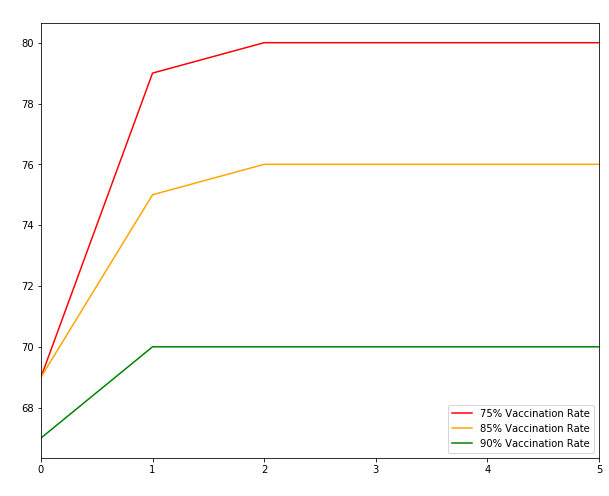

In [41]:
vac_figure = plt.figure(figsize=(10, 8))
# ax0 = vac_figure.add_subplot(111)
ax1 = vac_figure.add_subplot(111)
ax2 = vac_figure.add_subplot(111)
ax3 = vac_figure.add_subplot(111)

ax1.plot(results_list[1]['Unnamed: 0'], results_list[1]['Total Infected So Far'], color = 'red', label='75% Vaccination Rate')
ax2.plot(results_list[2]['Unnamed: 0'], results_list[2]['Total Infected So Far'], color = 'orange', label='85% Vaccination Rate')
ax3.plot(results_list[3]['Unnamed: 0'], results_list[3]['Total Infected So Far'], color = 'green', label = '90% Vaccination Rate')

plt.legend()
plt.title('Total Infected Over Time', color='b')
plt.xlabel('Number of Rounds', color='white')
plt.ylabel('Total Infected', color='white')
plt.xlim(0, 5)
plt.show()